In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dataset import *
from save_load import *
from NN_library.PINN import *
from NN_library.train_primal_PINN_int import *
from NN_library.train_dual_PINN_int import *
from matplotlib.tri import Triangulation
from utility import *
from PDE_losses import PDE_loss, PDE_loss_dual
%load_ext autoreload
%autoreload 2

Using device: cuda


In [2]:
data = dataset_grid(129, [0, 2*np.pi], [0, 2*np.pi])
loaders = get_loaders_Sobol(data, 129**2)

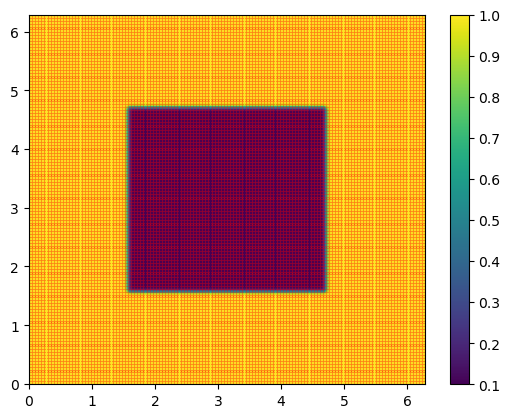

In [18]:
L = 2*np.pi
N = 512 # number of nodes in each direction including the border
x = np.linspace(0, L, N, endpoint=True)
y = np.linspace(0, L, N, endpoint=True)

XY = np.meshgrid(x, y)
grid_data = torch.tensor(np.vstack((XY[0].flatten(), XY[1].flatten())).T, dtype=torch.float, device=dev)

eps = 30
def a_function(x,y):
    x_dir = 0.5 + 0.5*np.tanh(eps*np.sin(x-np.pi/2))
    y_dir = 0.5 + 0.5*np.tanh(eps*np.sin(y-np.pi/2))
    a = 1 - 0.9*x_dir*y_dir
    return a

def A_interp(x): 
    x_dir = 0.5 + 0.5*torch.tanh(eps*torch.sin(x-torch.pi/2))
    a = 1 - 0.9*x_dir[:,0]*x_dir[:,1]
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a.view(-1,1,1) * I
    return A

def A_interp_inv(x):  
    x_dir = 0.5 + 0.5*torch.tanh(eps*torch.sin(x-torch.pi/2))
    a = 1 - 0.9*x_dir[:,0]*x_dir[:,1]
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = 1/a.view(-1,1,1) * I
    return A

def A(x):  
    x = x - torch.pi/2
    a = torch.where((x[:,0]<torch.pi)&(x[:,1]<torch.pi)&(x[:,0]>0)&(x[:,1]>0), 0.1, 1.).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a * I
    return A

def A_inv(x):  
    x = x - torch.pi/2
    a = torch.where((x[:,0]<torch.pi)&(x[:,1]<torch.pi)&(x[:,0]>0)&(x[:,1]>0), 0.1, 1.).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = (1 / a) * I
    return A

def H1(x):
    H = torch.zeros_like(x)
    H[:,0] = 1.
    return H

Z = a_function(XY[0].flatten(), XY[1].flatten())
plt.pcolormesh(XY[0], XY[1], Z.reshape(N, N))
plt.colorbar()
plt.scatter(data[:,0], data[:,1], s = 0.1, c='r')

# Primal PINN

In [19]:
net_primal = PINN(n_periodic=25, n_hidden=50, n_layers=5, period_len=L)
total_params = sum(p.numel() for p in net_primal.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.00001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/PINN/square/PINN_primal_{eps}_{total_params}'}

Number of parameters: 15601


In [20]:
net_primal = load_network(net_primal, args['name']+'_39999', args)
net_primal = net_primal.to(dev)

In [18]:
losses_train, losses_val = train_primal(net_primal, loaders, args, A_interp, H1, L)

Epoch: 0 mean train loss:  5.78713112e+01, bound:  8.07211280e-01
Epoch: 1 mean train loss:  5.77780266e+01, bound:  8.07029426e-01
Epoch: 2 mean train loss:  5.76853104e+01, bound:  8.06850135e-01
Epoch: 3 mean train loss:  5.75931816e+01, bound:  8.06673527e-01
Epoch: 4 mean train loss:  5.75016479e+01, bound:  8.06499720e-01
Epoch: 5 mean train loss:  5.74107094e+01, bound:  8.06328595e-01
Epoch: 6 mean train loss:  5.73203659e+01, bound:  8.06160212e-01
Epoch: 7 mean train loss:  5.72306137e+01, bound:  8.05994570e-01
Epoch: 8 mean train loss:  5.71414642e+01, bound:  8.05831552e-01
Epoch: 9 mean train loss:  5.70529060e+01, bound:  8.05671215e-01
Epoch: 10 mean train loss:  5.69649391e+01, bound:  8.05513620e-01
Epoch: 11 mean train loss:  5.68775635e+01, bound:  8.05358648e-01
Epoch: 12 mean train loss:  5.67907715e+01, bound:  8.05206239e-01
Epoch: 13 mean train loss:  5.67045708e+01, bound:  8.05056393e-01
Epoch: 14 mean train loss:  5.66189461e+01, bound:  8.04909229e-01
Epoch

In [19]:
np.save(f'NN_library/training_data/square/PINN_primal_{eps}_{total_params}', np.vstack([losses_train, losses_val]))

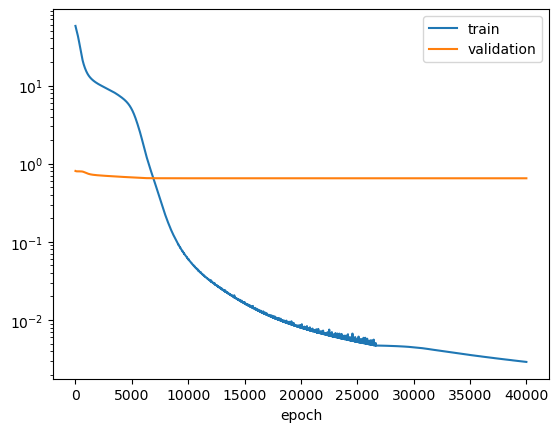

In [20]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [ ]:
U1 = net_primal(grid_data).detach().cpu()
error_1, _, _ = PDE_loss(grid_data, net_primal, A_interp, H1)
error_2, _, _ = PDE_loss(grid_data, net_primal, A, H1)

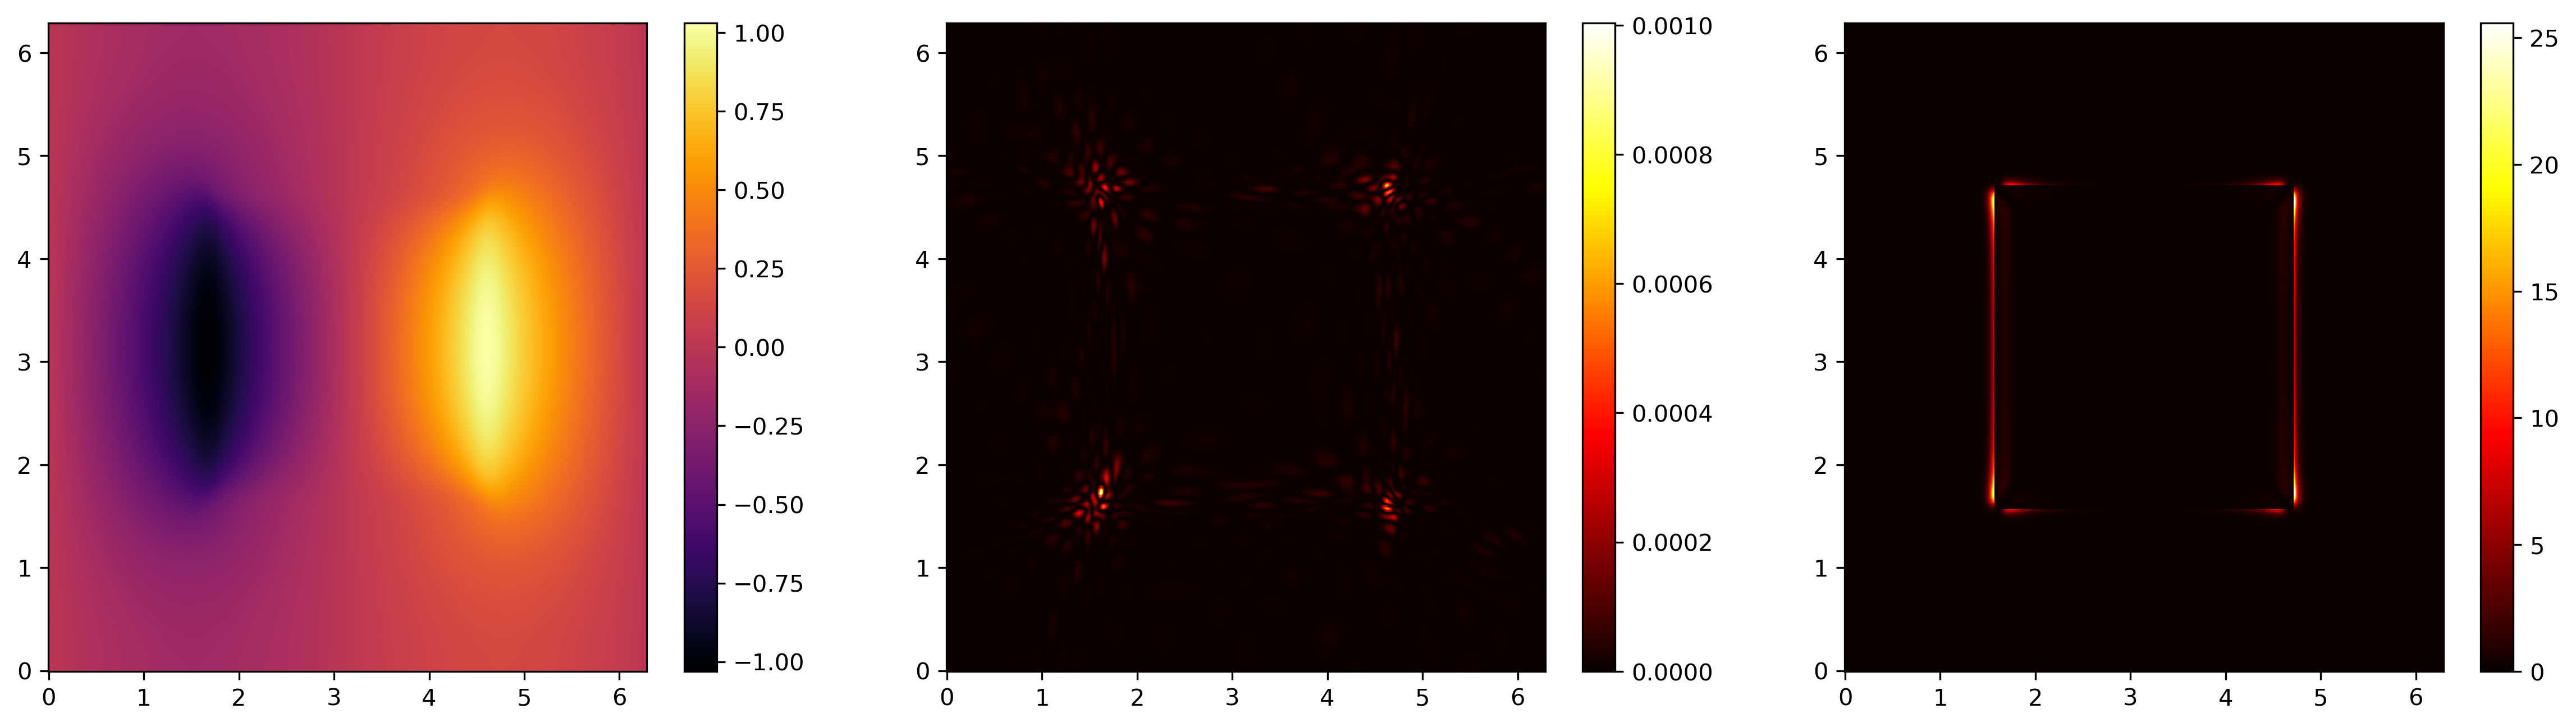

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U1.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_1.detach().cpu().reshape(N, N), cmap='hot')
fig.colorbar(pos2, ax=axs[1])
pos3 = axs[2].pcolormesh(XY[0], XY[1], error_2.detach().cpu().reshape(N, N), cmap='hot')
fig.colorbar(pos3, ax=axs[2])

In [21]:
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(args['dev'])
x = x.to(args['dev'])
x_rot = torch.fliplr(x)

_, q1, gH = PDE_loss(x, net_primal, A_interp, H1)
bound_1 = compute_estimate(areas, tri, q1, gH, L).detach().item()
print(bound_1)

U1 = net_primal(x)
U2 = net_primal(x_rot)

bound_2 = compute_bound_primal(U1, U2, tri, x, A, L)[0,0]
print(bound_2)

np.save(f'bounds/square/A_u_PINN_{total_params}_{eps}.npy', (bound_1, bound_2))

0.650534451007843
0.6491538800396371


# Dual PINN

In [21]:
net_dual = PINN(n_periodic=25, n_hidden=50, n_layers=5, period_len=L)
total_params = sum(p.numel() for p in net_dual.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.00001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/PINN/square/PINN_dual_{eps}_{total_params}'}

Number of parameters: 15601


In [22]:
net_dual = load_network(net_dual, args['name']+'_39999', args)
net_dual = net_dual.to(dev)

In [23]:
losses_train, losses_val = train_dual(net_dual, loaders, args, A_interp_inv, H1, L)

Epoch: 0 mean train loss:  5.34415186e+03, bound:  3.37852538e-01
Epoch: 1 mean train loss:  5.33111377e+03, bound:  3.37966383e-01
Epoch: 2 mean train loss:  5.31808105e+03, bound:  3.38079870e-01
Epoch: 3 mean train loss:  5.30505469e+03, bound:  3.38193029e-01
Epoch: 4 mean train loss:  5.29203320e+03, bound:  3.38305801e-01
Epoch: 5 mean train loss:  5.27901855e+03, bound:  3.38418126e-01
Epoch: 6 mean train loss:  5.26600928e+03, bound:  3.38530034e-01
Epoch: 7 mean train loss:  5.25300586e+03, bound:  3.38641405e-01
Epoch: 8 mean train loss:  5.24000781e+03, bound:  3.38752300e-01
Epoch: 9 mean train loss:  5.22701367e+03, bound:  3.38862747e-01
Epoch: 10 mean train loss:  5.21402441e+03, bound:  3.38972658e-01
Epoch: 11 mean train loss:  5.20103906e+03, bound:  3.39082122e-01
Epoch: 12 mean train loss:  5.18805664e+03, bound:  3.39191079e-01
Epoch: 13 mean train loss:  5.17507617e+03, bound:  3.39299530e-01
Epoch: 14 mean train loss:  5.16209766e+03, bound:  3.39407444e-01
Epoch

In [24]:
np.save(f'NN_library/training_data/square/PINN_dual_{eps}_{total_params}', np.vstack([losses_train, losses_val]))

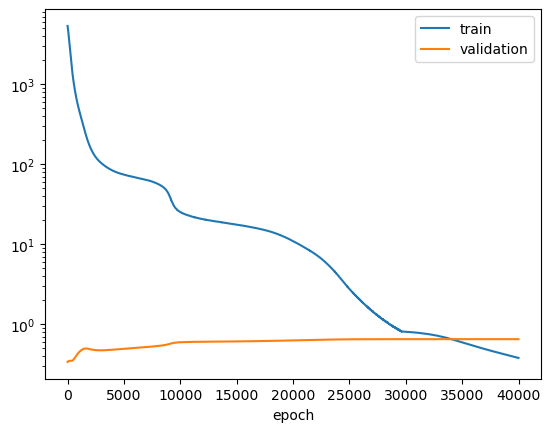

In [25]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [ ]:
W1 = net_dual(grid_data).detach().cpu()
error_1, _, _ = PDE_loss_dual(grid_data, net_dual, A_interp_inv, H1)
error_2, _, _ = PDE_loss_dual(grid_data, net_dual, A_inv, H1)

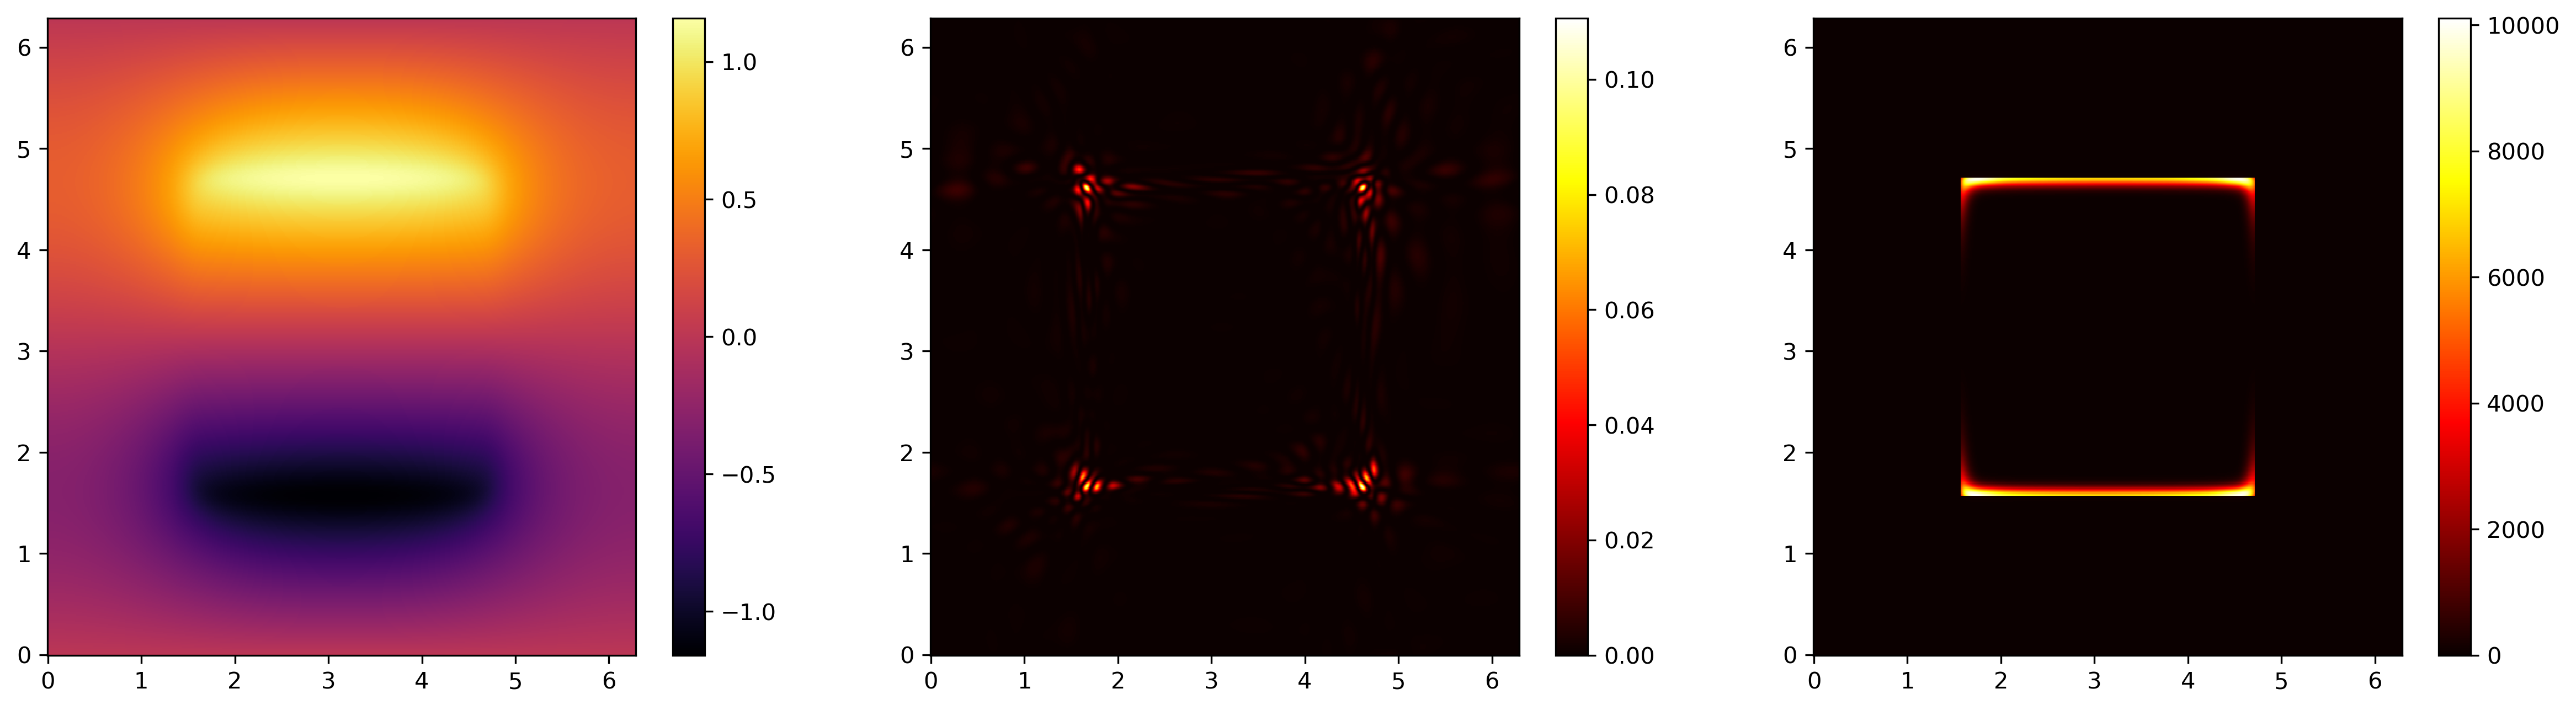

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], W1.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_1.detach().cpu().reshape(N, N), cmap='hot')
fig.colorbar(pos2, ax=axs[1])
pos3 = axs[2].pcolormesh(XY[0], XY[1], error_2.detach().cpu().reshape(N, N), cmap='hot')
fig.colorbar(pos3, ax=axs[2])

In [26]:
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(args['dev'])
x = x.to(args['dev'])
x_rot = torch.fliplr(x)
x_rot[:,1] = -x_rot[:,1]

_, q2, gH = PDE_loss_dual(x, net_dual, A_interp_inv, H1)
bound_1 = compute_estimate(areas, tri, q2, gH, L).detach().item()
print(1/bound_1)

W1 = net_dual(x)
W2 = net_dual(x_rot)

bound_2 = compute_bound_dual(W1, W2, tri, x, A_inv, L)[0,0]
print(bound_2)

np.save(f'bounds/square/A_l_PINN_{total_params}_{eps}.npy', (1/bound_1, bound_2))

0.6504779091985318
0.6400098714058816


## Draw

In [23]:
U1 = net_primal(grid_data).detach().cpu().reshape(N, N)
error_1_p, _, _ = PDE_loss(grid_data, net_primal, A_interp, H1)
error_1_p = error_1_p.detach().cpu().reshape(N, N)
U2 = net_dual(grid_data).detach().cpu().reshape(N, N)
error_1_d, _, _ = PDE_loss_dual(grid_data, net_dual, A_interp_inv, H1)
error_1_d = error_1_d.detach().cpu().reshape(N, N)

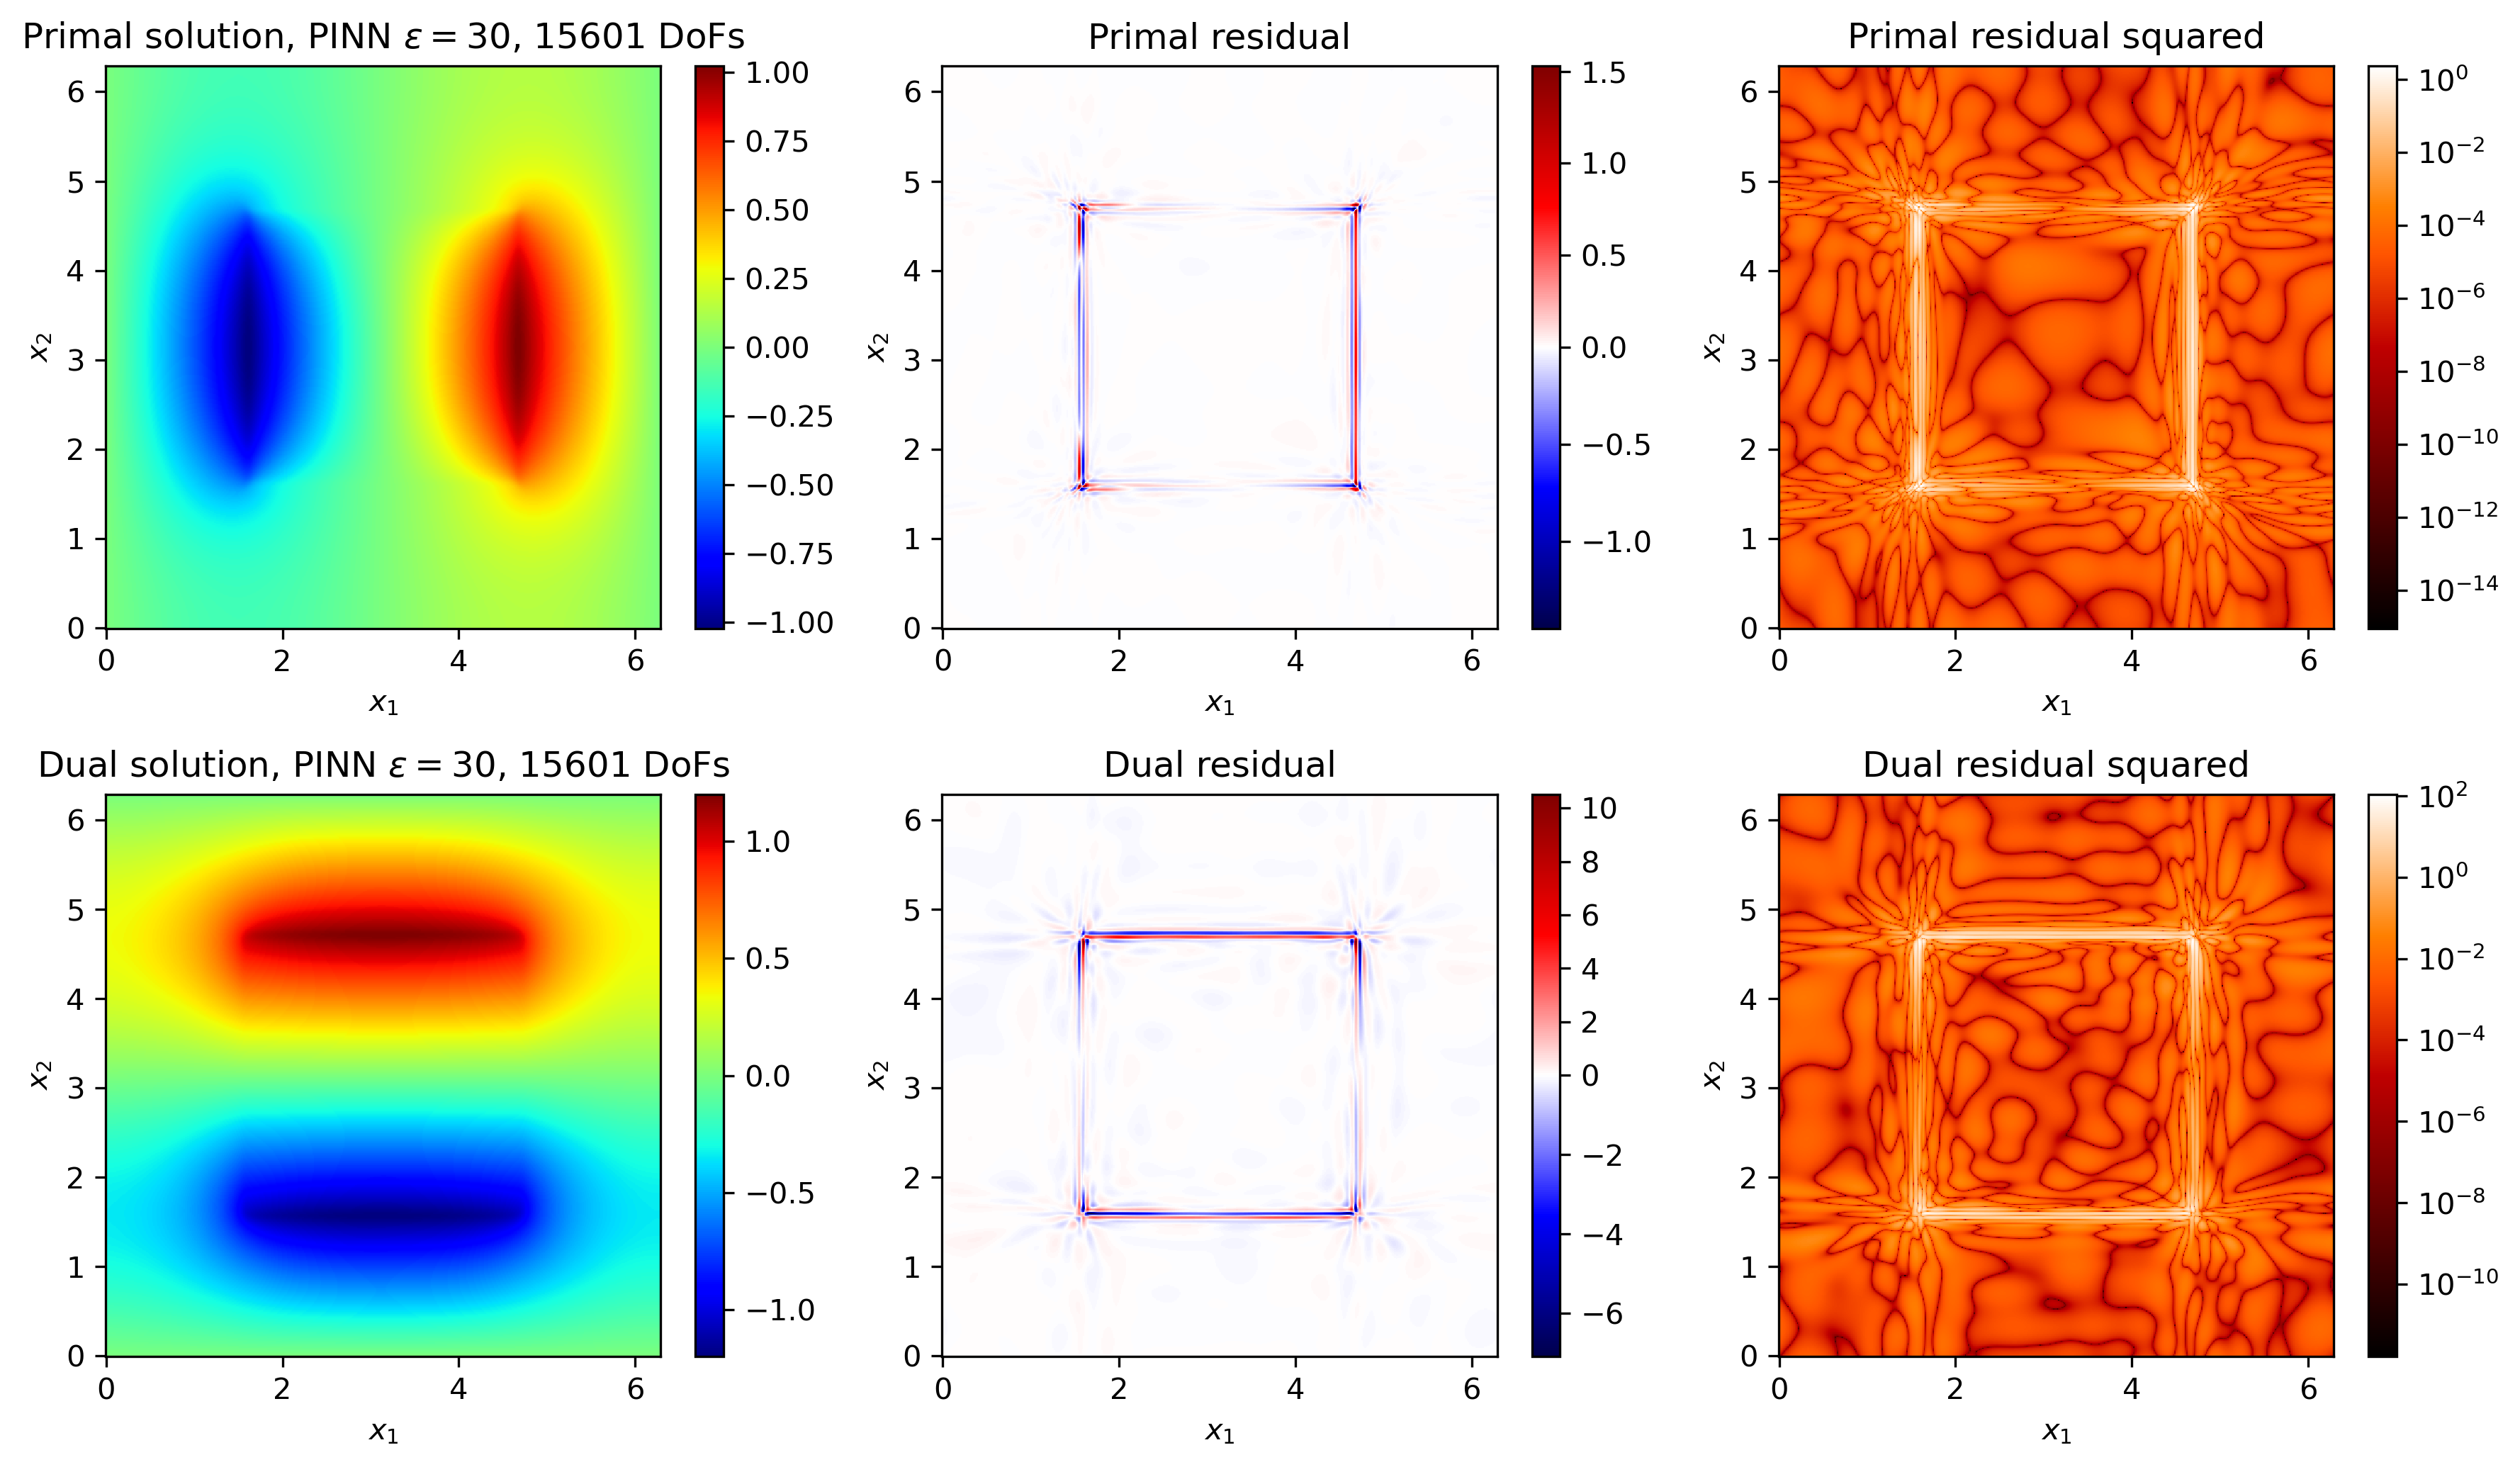

In [24]:
from matplotlib.colors import TwoSlopeNorm, LogNorm

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12,7), dpi=300)

for i in range(6):
    axs.flat[i].set_xlabel('$x_1$')
    axs.flat[i].set_ylabel('$x_2$')

pos1 = axs[0,0].pcolormesh(XY[0], XY[1], U1, cmap='jet')
fig.colorbar(pos1, ax=axs[0,0])
pos2 = axs[1,0].pcolormesh(XY[0], XY[1], U2, cmap='jet')
fig.colorbar(pos2, ax=axs[1,0])

axs[0,0].set_title(f'Primal solution, PINN $\epsilon={eps}$, {total_params} DoFs')
axs[1,0].set_title(f'Dual solution, PINN $\epsilon={eps}$, {total_params} DoFs')


pos1 = axs[0,1].pcolormesh(XY[0], XY[1], error_1_p, cmap='seismic', norm=TwoSlopeNorm(vmin=error_1_p.min(), vcenter=0, vmax=error_1_p.max()))
fig.colorbar(pos1, ax=axs[0,1])
pos2 = axs[1,1].pcolormesh(XY[0], XY[1], error_1_d, cmap='seismic', norm=TwoSlopeNorm(vmin=error_1_d.min(), vcenter=0, vmax=error_1_d.max()))
fig.colorbar(pos2, ax=axs[1,1])

axs[0,1].set_title('Primal residual')
axs[1,1].set_title('Dual residual')

pos1 = axs[0,2].pcolormesh(XY[0], XY[1], error_1_p**2, cmap='gist_heat', norm=LogNorm(vmin=(error_1_p**2).min(), vmax=(error_1_p**2).max()))
fig.colorbar(pos1, ax=axs[0,2])
pos2 = axs[1,2].pcolormesh(XY[0], XY[1], error_1_d**2, cmap='gist_heat', norm=LogNorm(vmin=(error_1_d**2).min(), vmax=(error_1_d**2).max()))
fig.colorbar(pos2, ax=axs[1,2])

axs[0,2].set_title('Primal residual squared')
axs[1,2].set_title('Dual residual squared')
plt.tight_layout()